# Quick, Draw!

## Some Useful Links
### Main
- Main Page: [QuickDraw](https://quickdraw.withgoogle.com)
- QuickDraw dataset repository, with many links to projects using it:
[here on github](https://github.com/googlecreativelab/quickdraw-dataset)

### Additional
- Demo drawings: [here](https://googlecreativelab.github.io/quickdraw-component/demo/#)
- closest to Zevi one can possibly get: [here](http://xinyue.de/scribbling-speech.html)
- in browser with [demo](https://zaidalyafeai.github.io/sketcher/) / [article](https://medium.com/tensorflow/train-on-google-colab-and-run-on-the-browser-a-case-study-8a45f9b1474e) / [notebook](https://colab.research.google.com/github/zaidalyafeai/zaidalyafeai.github.io/blob/master/sketcher/Sketcher.ipynb) / [code](https://github.com/zaidalyafeai/zaidalyafeai.github.io/tree/master/sketcher)
- python api: [here](https://quickdraw.readthedocs.io/en/latest/)
- sketch RNN blogpost: [here](https://ai.googleblog.com/2017/04/teaching-machines-to-draw.html)
- pix2pix for browser: [here](https://github.com/zaidalyafeai/zaidalyafeai.github.io/tree/master/pix2pix)
- magenta autocomplete: [here](https://magenta.tensorflow.org/sketch-rnn-demo)
- sketch RNN JS: [here](https://tensorflow.github.io/magenta-js/sketch/)
- TSNE mapping: [here](https://medium.com/@enjalot/machine-learning-for-visualization-927a9dff1cab)
- great tsne maps: [here](http://formafluens.io/client/iconolap.html)

## Helper Functions

In [0]:
# Copyright 2017 Google Inc.
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
# https://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import struct
from struct import unpack


def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    countrycode, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = unpack(fmt, file_handle.read(n_points))
        y = unpack(fmt, file_handle.read(n_points))
        image.append((x, y))

    return {
        'key_id': key_id,
        'countrycode': countrycode,
        'recognized': recognized,
        'timestamp': timestamp,
        'image': image
    }


def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break

In [0]:
def get_drawings(category):
    drawings = []
    for drawing in unpack_drawings(category+'.bin'):
        drawings.append(drawing)
    return drawings

In [0]:
import matplotlib.pyplot as plt

## Download Dataset

Full list of available categories can be found [here](https://github.com/googlecreativelab/quickdraw-dataset/blob/master/categories.txt).

In [0]:
!wget 'http://storage.googleapis.com/quickdraw_dataset/full/binary/cat.bin'

--2019-04-30 09:42:24--  http://storage.googleapis.com/quickdraw_dataset/full/binary/cat.bin
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19571324 (19M) [application/octet-stream]
Saving to: ‘cat.bin’

cat.bin             100%[===================>]  18.66M  --.-KB/s    in 0.1s    

2019-04-30 09:42:30 (159 MB/s) - ‘cat.bin’ saved [19571324/19571324]



## Visualise

In [0]:
cats = get_drawings('cat')

In [0]:
len(cats)

123202

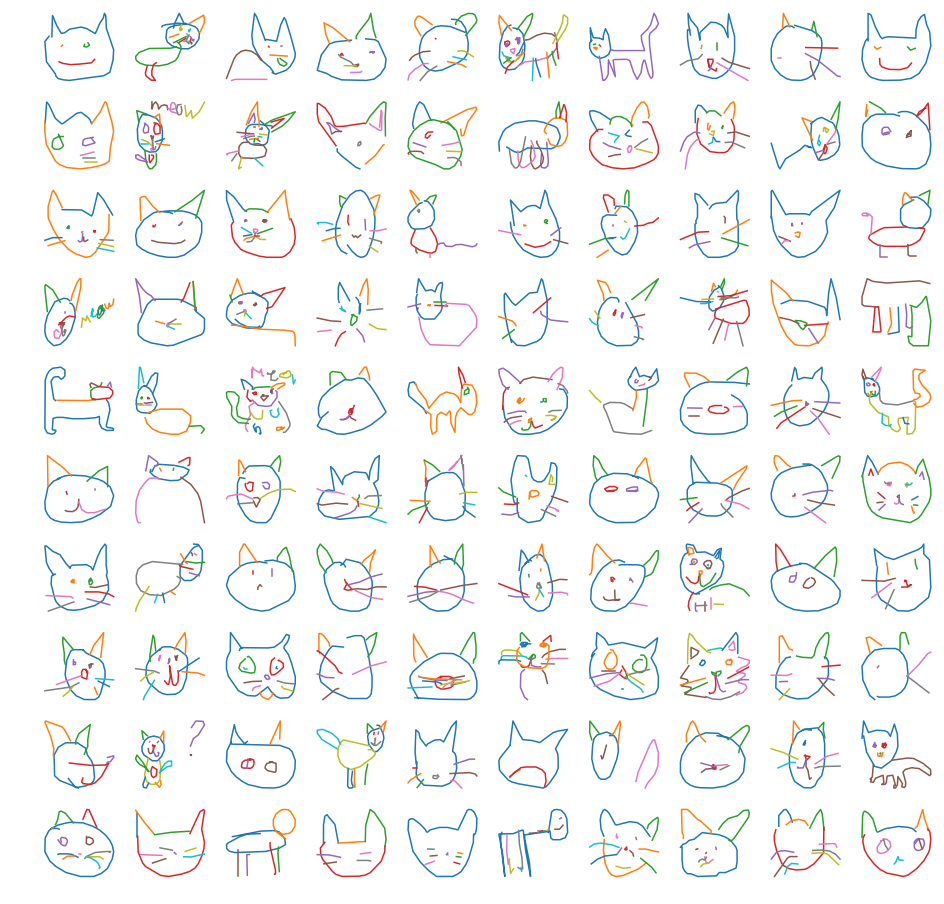

In [0]:
plt.figure(figsize=(16,16))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.axis('off')
    mycat = cats[100+i]['image']
    for s in mycat:
        ys = s[1]
        ys = [-y for y in ys]
        plt.plot(s[0],ys)

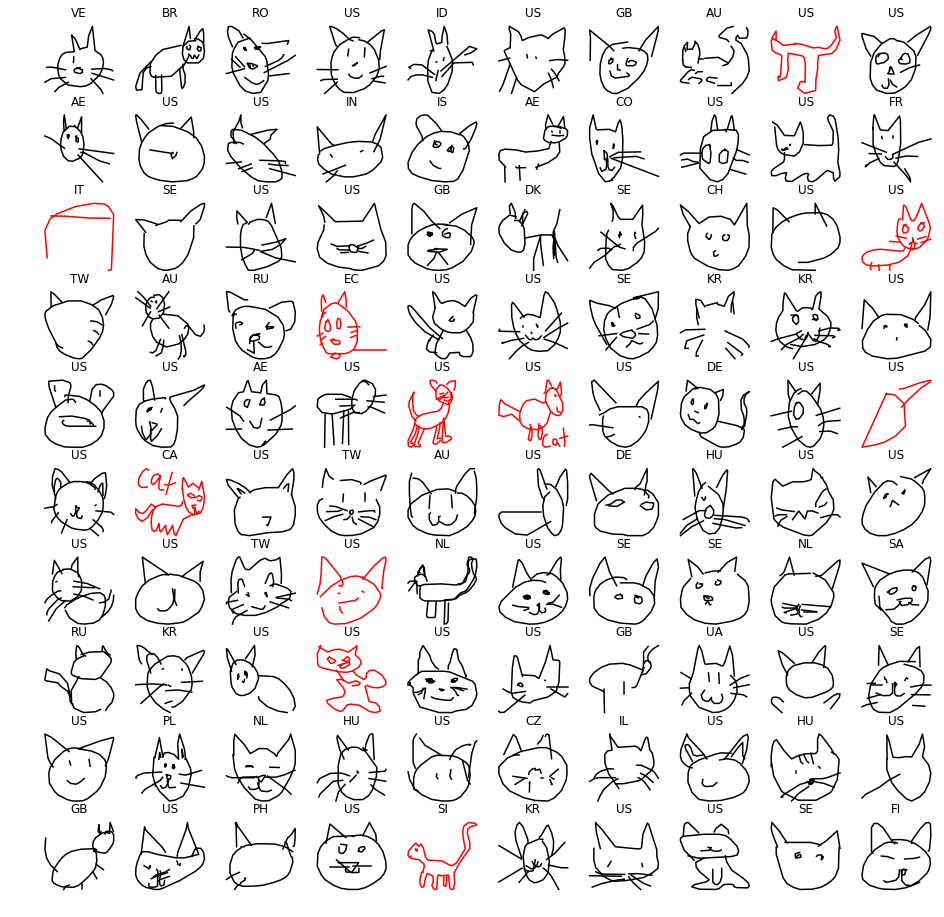

In [0]:
plt.figure(figsize=(16,16))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.axis('off')
    mycat = cats[i]['image']
    plt.title(cats[i]['countrycode'])
    col = 'k'
    if cats[i]['recognized']==0:
        col = 'r'
    for s in mycat:
        ys = s[1]
        ys = [-y for y in ys]
        plt.plot(s[0],ys,col)

## VAE

### Second set of imports

In [0]:
!git clone 'https://github.com/dbt-ethz/sketch_rnn_keras_mod.git'

Cloning into 'sketch_rnn_keras_mod'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 18 (delta 1), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [0]:
from sketch_rnn_keras_mod.utils import *
#from sketch_rnn_keras_mod.seq2seqVAE_train import *
#import sketch_rnn_keras_mod.seq2seqVAE as sketch_rnn_model
from sketch_rnn_keras_mod.seq2seqVAE import *

# import the required libraries
import numpy as np
import time
import random
#import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

Using TensorFlow backend.


In [0]:
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [0]:
# Function for encoding input and retrieving latent vector
def encode(input_strokes, draw=False):
    strokes = to_big_strokes(input_strokes, max_len=model_params['max_seq_len']-1).tolist()
    strokes.insert(0, [0, 0, 1, 0, 0])
    seq_len = [len(input_strokes)]
    #if draw:
    #    draw_strokes(to_normal_strokes(np.array(strokes)))
    strokes = np.expand_dims(strokes, axis=0)
    return seq2seq.sample_models['encoder_model'].predict(strokes)

In [0]:
# Function for decoding a latent space factor into a sketch
def decode(z_input=None, draw_mode=False, temperature=0.1, factor=0.2):
    z = None
    if z_input is not None:
        z = z_input
    sample_strokes, m = sample(seq2seq, seq_len=model_params.max_seq_len, temperature=temperature, z=z)
    strokes = to_normal_strokes(sample_strokes)
    #if draw_mode:
    #    draw_strokes(strokes, factor)
    return strokes

In [0]:
def interpolate_z(z_0, z_1, num=10, draw=False):
    z_list = [] # interpolate spherically between z0 and z1
    N = num
    for t in np.linspace(0, 1, N):
        z_list.append(slerp(z_0, z_1, t))
    # for every latent vector in z_list, sample a vector image
    reconstructions = []
    for i in range(N):
        reconstructions.append([decode(np.expand_dims(z_list[i],axis=0), draw_mode=False, temperature=0.01), [0, i]])
    
    #stroke_grid = make_grid_svg(reconstructions)
    #if draw:
    #    draw_strokes(stroke_grid)
    return reconstructions

In [0]:
!wget 'http://storage.googleapis.com/quickdraw_dataset/sketchrnn/cat.npz'

--2019-04-30 09:44:07--  http://storage.googleapis.com/quickdraw_dataset/sketchrnn/cat.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14842947 (14M) [application/octet-stream]
Saving to: ‘cat.npz’

cat.npz             100%[===================>]  14.16M  --.-KB/s    in 0.1s    

2019-04-30 09:44:07 (138 MB/s) - ‘cat.npz’ saved [14842947/14842947]



In [0]:
!wget 'http://storage.googleapis.com/quickdraw_dataset/sketchrnn/guitar.npz'

--2019-04-30 09:44:11--  http://storage.googleapis.com/quickdraw_dataset/sketchrnn/guitar.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15700945 (15M) [application/octet-stream]
Saving to: ‘guitar.npz’

guitar.npz          100%[===================>]  14.97M  --.-KB/s    in 0.09s   

2019-04-30 09:44:12 (174 MB/s) - ‘guitar.npz’ saved [15700945/15700945]



### Load Model

In [0]:
data_dir = './'
with open('sketch_rnn_keras_mod/model/model_config.json','r') as f:
    model_params = json.load(f)
model_params = DotDict(model_params)

In [0]:
model_params

{u'accelerate_LSTM': False,
 u'augment_stroke_prob': 0.1,
 u'batch_size': 100,
 u'data_set': [u'cat.npz', u'guitar.npz'],
 u'dec_rnn_size': 1024,
 u'decay_rate': 0.9999,
 u'enc_rnn_size': 256,
 u'epochs': 100,
 u'grad_clip': 1.0,
 u'is_training': True,
 u'kl_decay_rate': 0.99995,
 u'kl_tolerance': 0.2,
 u'kl_weight': 0.5,
 u'kl_weight_start': 0.01,
 u'learning_rate': 0.001,
 u'max_seq_len': 129,
 u'min_learning_rate': 1e-05,
 u'num_mixture': 20,
 u'optimizer': u'adam',
 u'random_scale_factor': 0.15,
 u'recurrent_dropout_prob': 0.9,
 u'save_every': None,
 u'use_recurrent_dropout': True,
 u'z_size': 128}

In [0]:
weights = 'sketch_rnn_keras_mod/model/weights.hdf5' # checkpoint path
seq2seq = Seq2seqModel(model_params)  # build model
seq2seq.load_trained_weights(weights) # load checkpoint
seq2seq.make_sampling_models()  # build sub models that are used to infuse inputs and probe values of intermediate layers

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 129, 5)       0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 512)          536576      encoder_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          65664       bidirectional_1[0][0]            
__________________________________________________________________________________________________
dense_2 (Dense)      

In [0]:
[train_set, valid_set, test_set, hps_model] = load_dataset(data_dir, model_params)

Loaded 70000/2500/2500 from cat.npz
Loaded 70000/2500/2500 from guitar.npz
Dataset combined: 150000 (140000/5000/5000), avg len 70
model_params.max_seq_len: 129
total images <= max_seq_len is 140000
total images <= max_seq_len is 5000
total images <= max_seq_len is 5000
normalizing_scale_factor  51.59792


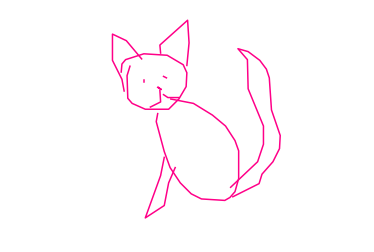

In [0]:
mysketch = test_set.random_sample()
myabssk = strokes_to_lines(mysketch)
plt.axis('equal')
plt.axis('off')
for s in myabssk:
    xs = [v[0] for v in s]
    ys = [-v[1] for v in s]
    plt.plot(xs,ys,'#FF0088')

In [0]:
z_cat = encode(mysketch)

In [0]:
z_cat

array([[-0.02142036, -1.1997409 , -0.04628336, -0.88584983,  0.46404827, -1.2792215 , -0.89957774,  0.5360162 , -1.3444613 ,  0.183651  ,  1.036724  , -0.43073314,  1.8717191 ,  0.38877472,
         0.9169515 ,  0.54336536,  0.41810468,  0.11568803, -0.6459234 ,  0.3573045 , -0.06610625,  1.2513913 ,  1.0231878 ,  0.33653897, -0.6514759 , -0.5620176 ,  0.48053434,  1.89962   ,
         0.13479936,  0.04649277,  0.7097535 , -0.85809004,  0.9225173 ,  0.39019135, -0.21820304,  0.43259543,  1.6725379 , -0.45019293,  0.29327992, -0.10567213,  0.488227  , -0.2760945 ,
        -0.8495613 , -0.27351364, -0.91843855, -0.5804744 ,  1.5676492 , -0.67566794,  0.6170678 ,  0.1495322 ,  0.7594475 , -2.1112695 ,  0.23154993,  0.05539545,  0.7533251 ,  0.1539008 ,
         0.03000916,  0.10796752, -0.00025761, -0.06512449, -1.0739    ,  0.47860605,  1.4381217 , -0.866445  ,  2.1114762 ,  0.8269314 , -1.6107827 ,  0.5861237 ,  1.2449191 , -0.73804426,
         1.7110957 ,  0.9486814 , -0.25313193, -0.

In [0]:
decoded_cat = decode(z_cat,temperature=0.01)

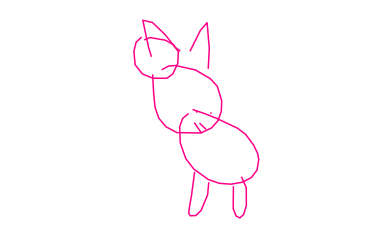

In [0]:
myabssk = strokes_to_lines(decoded_cat)
plt.axis('equal')
plt.axis('off')
for s in myabssk:
    xs = [v[0] for v in s]
    ys = [-v[1] for v in s]
    plt.plot(xs,ys,'#FF0088')

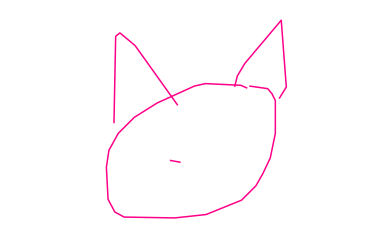

In [0]:
mysketch = test_set.strokes[8]
myabssk = strokes_to_lines(mysketch)
plt.axis('equal')
plt.axis('off')
for s in myabssk:
    xs = [v[0] for v in s]
    ys = [-v[1] for v in s]
    plt.plot(xs,ys,'#FF0088')

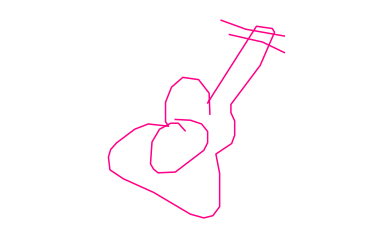

In [0]:
mysketch = test_set.strokes[1005]
myabssk = strokes_to_lines(mysketch)
plt.axis('equal')
plt.axis('off')
for s in myabssk:
    xs = [v[0] for v in s]
    ys = [-v[1] for v in s]
    plt.plot(xs,ys,'#FF0088')

In [0]:
z0 = encode(test_set.strokes[8])
z1 = encode(test_set.strokes[1005])

In [0]:
z0 = np.squeeze(z0)
z1 = np.squeeze(z1)

In [0]:
num = 15
blends = interpolate_z(z0,z1,num=num)

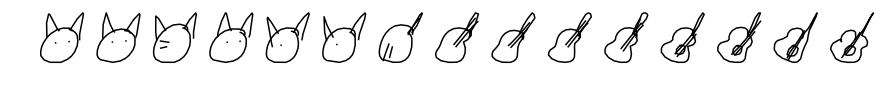

In [0]:
plt.figure(figsize=(15,1))
plt.axis('equal')
for i in range(num):
    step = strokes_to_lines(blends[i][0])
    plt.subplot(1,num,i+1)
    plt.axis('off')
    for s in step:
        xs = [v[0] for v in s]
        ys = [-v[1] for v in s]
        plt.plot(xs,ys,'k')

In [0]:
#z1.shape
invcat = decode(-z1.reshape(1,128),temperature=0.01)

In [0]:
z1.shape

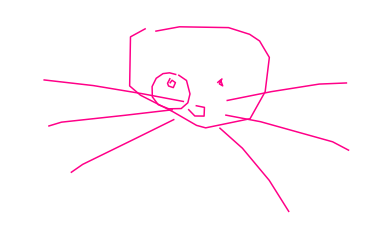

In [0]:
myabssk = strokes_to_lines(invcat)
plt.axis('equal')
plt.axis('off')
for s in myabssk:
    xs = [v[0] for v in s]
    ys = [-v[1] for v in s]
    plt.plot(xs,ys,'#FF0088')



```
# This is formatted as code
```

## Dimensionality Reduction

In [0]:
from sklearn import manifold

In [0]:
# this cell is prone to failure (error with encoding, assertion error)
# solution: run again. and again...
X = np.empty((1000,128))
idxs = list(range(5000))
random.shuffle(idxs)
for i in range(1000):
    s = test_set.strokes[idxs[i]]
    X[i,:] = encode(s)

In [0]:
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=80)
X_tsne = tsne.fit_transform(X)

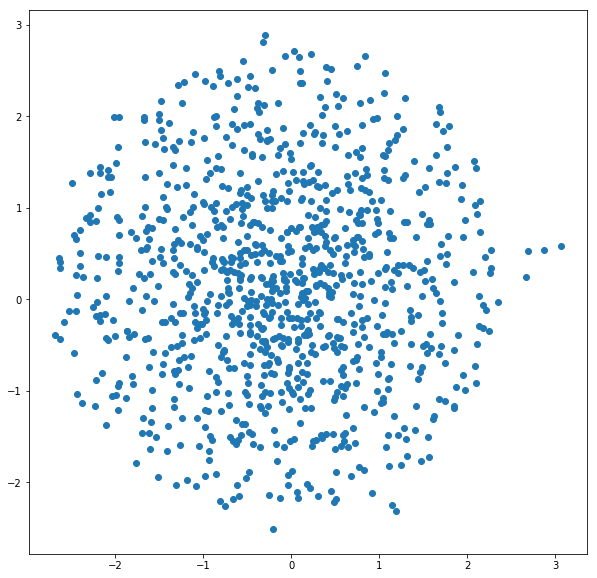

In [0]:
plt.figure(figsize=(10,10))
plt.scatter(*X_tsne.T)

In [0]:
X_tsne.shape

(1000, 2)

In [0]:
indices = []
for i in range(1000):
    if abs(X_tsne[i,0]+0.5)<0.3 and abs(X_tsne[i,1]+1.5)<0.3:
        indices.append(i)

In [0]:
len(indices)

15

In [0]:
indices

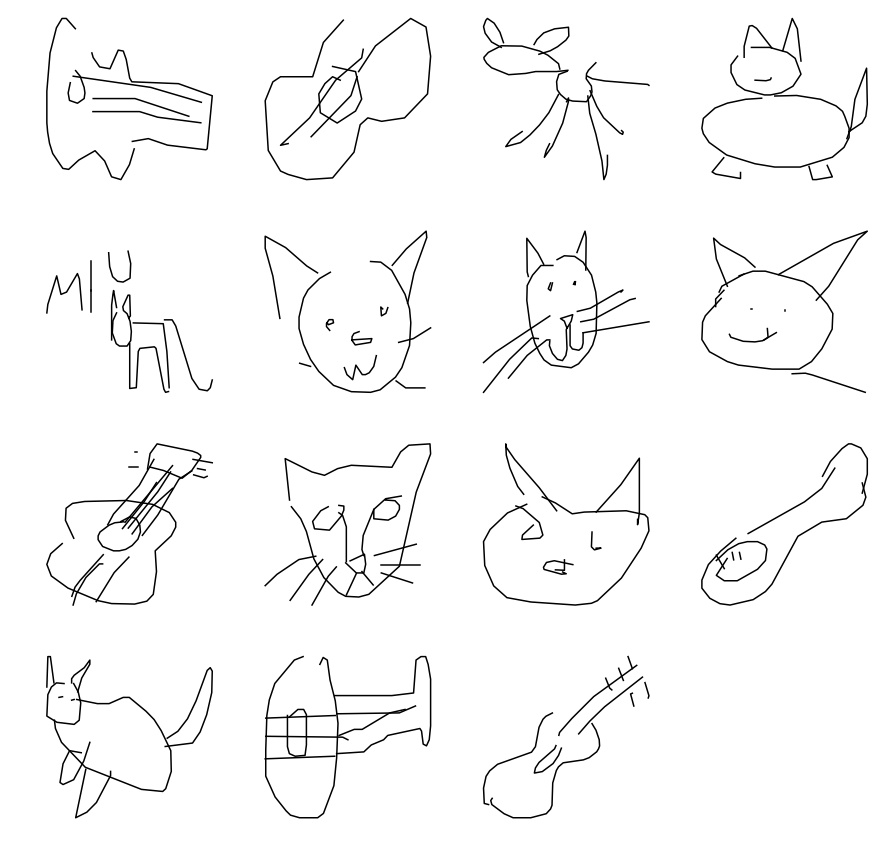

In [0]:
plt.figure(figsize=(15,15))
plt.axis('equal')
for i in range(15):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    idx = indices[i]
    stid = idxs[idx]
    decstrokes = strokes_to_lines(test_set.strokes[stid])
    for s in decstrokes:
        xs = [v[0] for v in s]
        ys = [-v[1] for v in s]
        plt.plot(xs,ys,'k')